In [3]:
from google.colab import files
import os

# --- Colab File Upload ---
print("Please upload the following three files when prompted:")
print("1. dengue lab test.csv")
print("2. z1.csv")
print("3. Jinnah Pharmacy 4.csv")
print("-" * 30)

# This will open a file chooser dialog for you to select the files
uploaded = files.upload()

# Check if all files were uploaded (optional but recommended)
required_files = ['dengue lab test (2).csv', 'z1 (2).csv', 'Jinnah Pharmacy 4 (2).csv']
for filename in required_files:
    if filename not in uploaded:
        print(f"\nERROR: File '{filename}' was not uploaded. Please re-run the cell and upload all files.")
        break
else:
    print("\nAll files uploaded successfully. Proceed to the main analysis code.")

Please upload the following three files when prompted:
1. dengue lab test.csv
2. z1.csv
3. Jinnah Pharmacy 4.csv
------------------------------


Saving dengue lab test.csv to dengue lab test (2).csv
Saving Jinnah Pharmacy 4.csv to Jinnah Pharmacy 4 (2).csv
Saving z1.csv to z1 (2).csv

All files uploaded successfully. Proceed to the main analysis code.


Dengue Positive Tests Forecast (Q4 2024)
      date  actual_tests  predicted_tests
2024-10-01             5                6
2024-10-02             1                7
2024-10-03            16               16
2024-10-04             7                8
2024-10-05             5                5
2024-10-06             3                5
2024-10-07            15               12
2024-10-08            22                3
2024-10-09             1                5
2024-10-10            13                6
2024-10-11             0                5
2024-10-12             1               14
2024-10-13             6                5
2024-10-14             5                6
2024-10-15             5                8
2024-10-16             1                4
2024-10-17             3               10
2024-10-18             1                3
2024-10-19             4                4
2024-10-20            19               10
2024-10-21             7                5
2024-10-22             7           

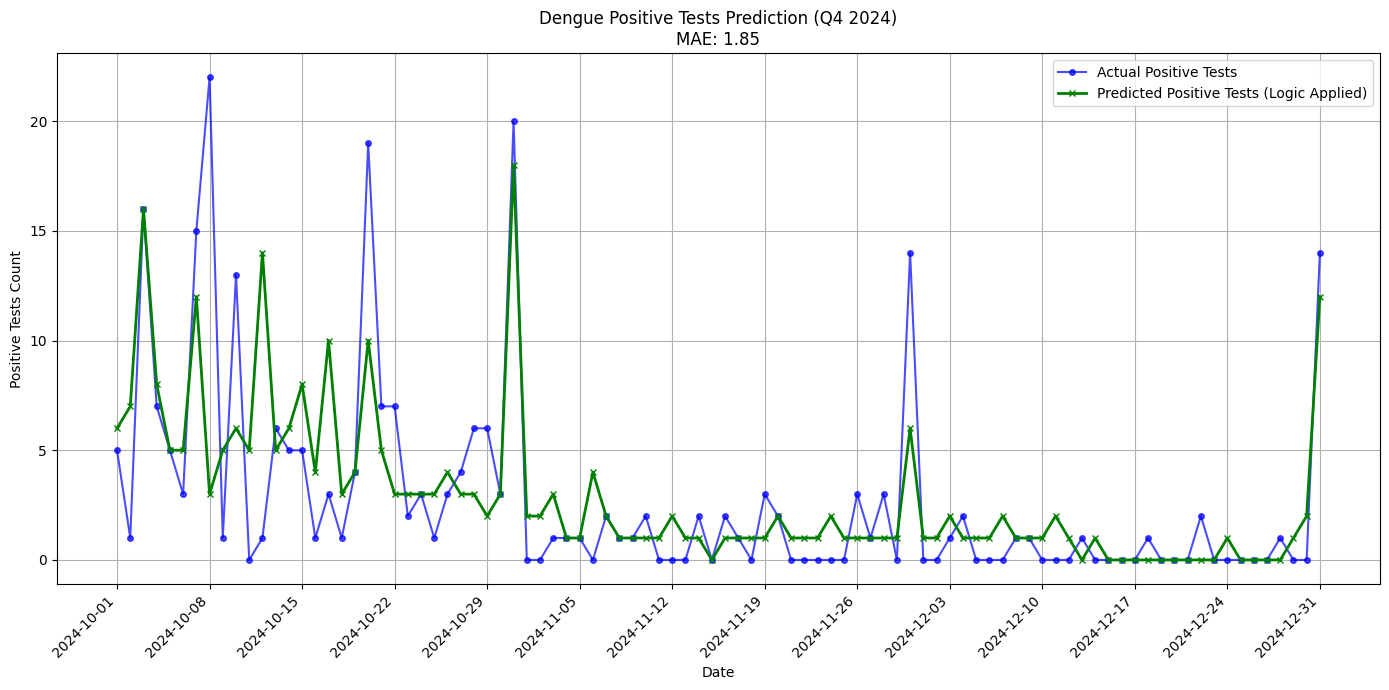

In [4]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# --- PANDAS DISPLAY FIX ---
pd.set_option('display.max_rows', None)

# --- 1. Constants ---
LAGS = 14
FEATURES_TO_LAG = ['positive_tests', 'Panadol', 'Calpol']
TRAIN_END_DATE = '2024-09-30'
PREDICT_START_DATE = '2024-10-01'
PREDICT_END_DATE = '2024-12-31'

# --- 2. Feature Engineering Function ---
def create_features_with_current_sales(df, features_to_lag, lags):
    df_feat = df.copy()
    for col in features_to_lag:
        for lag in range(1, lags + 1):
            if col == 'positive_tests':
                df_feat[f'{col}_lag{lag}'] = np.log1p(df_feat[col]).shift(lag)
            else:
                df_feat[f'{col}_lag{lag}'] = df_feat[col].shift(lag)

    df_feat['pos7'] = df_feat['positive_tests'].shift(1).rolling(window=7).mean()
    df_feat['pos14'] = df_feat['positive_tests'].shift(1).rolling(window=14).mean()
    df_feat['dow'] = df_feat['date'].dt.dayofweek
    df_feat['dom'] = df_feat['date'].dt.day
    df_feat['month'] = df_feat['date'].dt.month
    df_feat['y'] = np.log1p(df_feat['positive_tests'])
    df_feat.dropna(inplace=True)
    return df_feat

# --- 3. Data Loading with CORRECT DATE FORMATS ---

# 3.1 Load Dengue Lab Test Data (Day First: dd/mm/yyyy)
df_lab = pd.read_csv('dengue lab test.csv')
# FORCE dayfirst=True
df_lab['date'] = pd.to_datetime(df_lab['date'], dayfirst=True, errors='coerce')
df_lab = df_lab[['date', 'positive_tests']]

# 3.2 Load 2023 Sales Data (z1.csv is Month First: mm/dd/yyyy)
df_sales_2023 = pd.read_csv('z1.csv')
df_sales_2023.rename(columns={'Panadol_Sales': 'Panadol', 'Calpol_Sales': 'Calpol'}, inplace=True)
# FORCE format to match the synthetic data generation
df_sales_2023['date'] = pd.to_datetime(df_sales_2023['date'], format='%m/%d/%Y', errors='coerce')
df_sales_2023 = df_sales_2023[['date', 'Panadol', 'Calpol']]

# 3.3 Load 2024 Sales Data (Jinnah Pharmacy is Day First)
df_pharmacy_2024 = pd.read_csv('Jinnah Pharmacy 4.csv')
df_pharmacy_2024.rename(columns={'brand_name': 'medicine', 'total_sales': 'sale'}, inplace=True)
# FORCE dayfirst=True
df_pharmacy_2024['date'] = pd.to_datetime(df_pharmacy_2024['date'], dayfirst=True, errors='coerce')

df_sales_2024_filtered = df_pharmacy_2024[df_pharmacy_2024['medicine'].isin(['Panadol', 'Calpol'])]
df_sales_2024_pivot = df_sales_2024_filtered.pivot_table(
    index='date', columns='medicine', values='sale', aggfunc='sum'
).reset_index()

# Combine Sales
df_sales_combined = pd.concat([df_sales_2023, df_sales_2024_pivot], ignore_index=True)
df_sales_combined.sort_values('date', inplace=True)
df_sales_combined.fillna(0, inplace=True)

# Merge with Lab Data
df_master = pd.merge(df_lab, df_sales_combined, on='date', how='inner')
df_master.sort_values('date', inplace=True)
df_master.reset_index(drop=True, inplace=True)

# *** Calculate Total Sales (Required for logic) ***
df_master['Total_Sales'] = df_master['Panadol'] + df_master['Calpol']

# --- 4. Feature Engineering & Split ---
df_features = create_features_with_current_sales(df_master, FEATURES_TO_LAG, LAGS)

df_train = df_features[df_features['date'] <= TRAIN_END_DATE].copy()
df_predict = df_features[
    (df_features['date'] >= PREDICT_START_DATE) & (df_features['date'] <= PREDICT_END_DATE)
].copy()

feature_cols = [col for col in df_train.columns if col.startswith(('positive_tests_lag', 'Panadol_lag', 'Calpol_lag', 'pos7', 'pos14', 'dow', 'dom', 'month'))]
feature_cols.extend(['Panadol', 'Calpol'])

X_train = df_train[feature_cols]
y_train = df_train['y']
X_predict_base = df_predict[feature_cols].copy()
actual_values = df_predict[['date', 'positive_tests']].copy()

# --- 5. Train Model ---
rf_regressor = RandomForestRegressor(n_estimators=300, random_state=42)
rf_regressor.fit(X_train, y_train)

# --- 6. Recursive Prediction Loop ---
df_pred_results = actual_values.copy()
df_pred_results.set_index('date', inplace=True)
df_pred_results.rename(columns={'positive_tests': 'actual_tests'}, inplace=True)
df_pred_results['predicted_tests'] = np.nan

# Lookup dictionary for sales logic
sales_lookup = df_master.set_index('date')['Total_Sales'].to_dict()

for i in range(len(df_pred_results)):
    date_i = df_pred_results.index[i]
    current_features = X_predict_base.iloc[[i]].copy()

    if i > 0:
        pred_val_yesterday = df_pred_results['predicted_tests'].iloc[i-1]
        log_pred_yesterday = np.log1p(pred_val_yesterday)

        for lag in range(LAGS, 1, -1):
            current_features[f'positive_tests_lag{lag}'] = current_features[f'positive_tests_lag{lag-1}']
        current_features['positive_tests_lag1'] = log_pred_yesterday

    log_pred_i = rf_regressor.predict(current_features)[0]
    pred_i = np.expm1(log_pred_i)
    pred_i = max(0, round(pred_i))

    # *** LOGIC: Double if sales increased for 2 consecutive days ***
    sales_t = sales_lookup.get(date_i, 0)
    date_minus_1 = date_i - pd.Timedelta(days=1)
    date_minus_2 = date_i - pd.Timedelta(days=2)
    sales_t_minus_1 = sales_lookup.get(date_minus_1, 0)
    sales_t_minus_2 = sales_lookup.get(date_minus_2, 0)

    # If today's sales > yesterday AND today's sales > day before yesterday
    if (sales_t > sales_t_minus_1) and (sales_t > sales_t_minus_2):
        pred_final = pred_i * 2
    else:
        pred_final = pred_i

    df_pred_results.loc[date_i, 'predicted_tests'] = pred_final

# --- 7. Output ---
df_comp = df_pred_results.reset_index()
df_comp['predicted_tests'] = df_comp['predicted_tests'].astype(int)
df_comp['actual_tests'] = df_comp['actual_tests'].astype(int)
df_comp['date'] = df_comp['date'].dt.strftime('%Y-%m-%d')

mae_value = mean_absolute_error(df_comp['actual_tests'], df_comp['predicted_tests'])

print("="*50)
print("Dengue Positive Tests Forecast (Q4 2024)")
print("="*50)
print(df_comp[['date', 'actual_tests', 'predicted_tests']].to_string(index=False))

print("\n" + "="*50)
print(f"Mean Absolute Error (MAE): {mae_value:.2f} cases")
print("="*50)

plt.figure(figsize=(14, 7))
plt.plot(df_pred_results.index, df_pred_results['actual_tests'], label='Actual Positive Tests', color='blue', linewidth=1.5, marker='o', markersize=4, alpha=0.7)
plt.plot(df_pred_results.index, df_pred_results['predicted_tests'], label='Predicted Positive Tests (Logic Applied)', color='green', linestyle='-', linewidth=2, marker='x', markersize=5)
plt.title(f'Dengue Positive Tests Prediction (Q4 2024)\nMAE: {mae_value:.2f}')
plt.xlabel('Date')
plt.ylabel('Positive Tests Count')
plt.legend()
plt.grid(True)
plt.xticks(df_pred_results.index[::7], rotation=45, ha='right')
plt.tight_layout()
plt.show()